# Odkrivanje skupin in izris kart dokumentov

Dimenzionalnost vektorskih predstavitev dokumentov lahko zmanjšamo na 2, kar nam omogoča prikaz dvodimenzionalne karte dokumentov, na kateri vsaka točka predstavlja dokument. Poleg tega lahko v dvodimenzionalnem prostoru odkrijemo skupine podobnih dokumentov in vsako skupino na karti obarvamo z različno barvo. To nam omogoča dober vpogled v celotno množico dokumentov.

Za začetek si spet preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov ter iz datoteke preberemo fastText vektorje iz prejšnjega primera.

In [1]:
from textsemantics.server_api import ServerAPI
import numpy as np
from scipy.sparse import load_npz

api = ServerAPI()
datasets = api.list_datasets()
metadata = api.get_metadata(datasets[2][0], sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

ft = np.load('data/ft.npy')

In [2]:
from openTSNE.sklearn import TSNE
tsne = TSNE().fit(ft)

In [3]:
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=2, min_samples=1).fit(tsne.embedding_)
labels = hdbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Število skupin: {n_clusters}, Število dokumentov, ki niso v skupinah: {n_noise}")

Število skupin: 33, Število dokumentov, ki niso v skupinah: 15


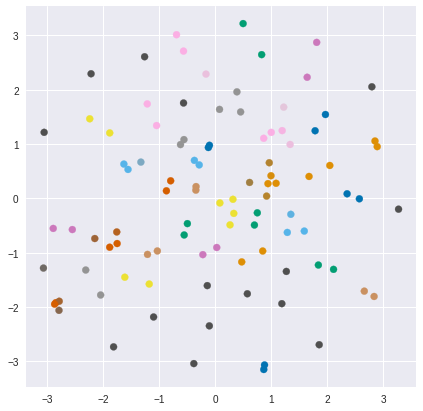

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(7, 7))
plt.style.use('seaborn')
idx = np.where(labels > -1)[0]
palette = sns.color_palette('colorblind', n_clusters)
colors = [sns.desaturate(palette[l] if l >= -1 else (0.5, 0.5, 0.5), p) for 
          l, p in zip(hdbscan.labels_, hdbscan.probabilities_)]
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=colors,
            cmap=plt.get_cmap('Spectral'))

Če bi pogledali dokumente, ki se nahajajo v eni izmed skupin, bi opazili, da se nanašajo na isto ali podobno temo.